# Generating Hierarchical Data


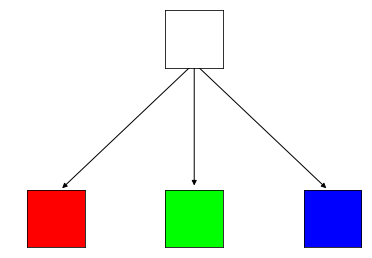

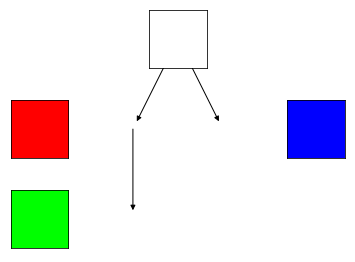

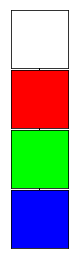

In [21]:
from typing import List, Dict
from PIL import Image
from IPython.display import display
from hierarchy_plotting import *
%matplotlib inline

image_width = 5
samples_per_pixel = 100

two_level_tree =\
[Node('white', [
        Node('red', None),
        Node('green', None),
        Node('blue', None)
    ])
]

three_level_tree =\
[Node('white', [
        Node('red', [
            Node('green', None)
        ]),
        Node('blue', None)
    ])
]

four_level_tree =\
[Node('white', [
        Node('red', [
            Node('green', [
                Node('blue', None)
            ])
        ])
    ])
]

def create_color_image(color, save=None):
    img = Image.new('RGB', (5, 5), color=color)
    if save:
        plt.imsave(save + '.png', np.array(img), vmin=0, vmax=255)
    return np.array(img, dtype=np.uint8)

create_color_image((255, 255, 255), 'output/white')
create_color_image((255, 0, 0), 'output/red')
create_color_image((0, 255, 0), 'output/green')
create_color_image((0, 0, 255), 'output/blue')

def show_tree(tree):
    G = nx.DiGraph()
    build_graph_from_tree(G, tree, 'output/{}.png')
    tree_fig : plt.Figure = plt.figure()
    plot_image_hierarchy(tree_fig, G)
    tree_fig.savefig('output/sivic-3a-top.png')
    tree_fig.show()
    return tree_fig

two_level_tree_fig = show_tree(two_level_tree)
three_level_tree_fig = show_tree(three_level_tree)
four_level_tree_fig = show_tree(four_level_tree)


Now to generate images!


In [72]:
def sample_path(tree : List[Node], prior : Dict[str, int], partial_path = None, path_weights=None):
    if partial_path is None:
        partial_path = list()
        path_weights = {k: 0 for k in prior.keys()}
    if tree is None:
        return partial_path, path_weights
    weights = np.array([prior[node[0]] for node in tree])
    choice = np.argmax(np.random.multinomial(1, weights / float(np.sum(weights))))
    next_node = tree[choice]
    path_weights[next_node[0]] = prior[next_node[0]]
    return sample_path(next_node[1], prior, partial_path + [next_node], path_weights)

def sample_path_weights_dp(path, eta):
    weights = {'white': 0, 'red': 0, 'green': 0, 'blue': 0}
    stick_len = 1
    for node in path[:-1]:
        weights[node[0]] = stick_len * np.random.beta(1, eta)
        stick_len -= weights[node[0]]
    weights[path[-1][0]] = stick_len
    return weights

def sample_topic_weights_dirichlet(topic_names, alpha):
    weights = np.random.dirichlet([alpha] * len(topic_names))
    return {name: weights[i] for i, name in enumerate(topic_names)}

def sample_words(num_words, prior, beta):
    keys = list(prior.keys())
    weights = np.array([prior[node_name] + beta for node_name in keys])
    words = np.random.multinomial(num_words, weights / float(np.sum(weights)))
    return {keys[i]: words[i] for i in range(len(keys))}

def generate_image(image_size, tree, alpha, beta, eta, num_words=100):
    image = Image.new('RGB', (image_size, image_size), color=(0,0,0))
    pixels = image.load()
    path_prior = {'white': 0, 'red': 0, 'green': 0, 'blue': 0}
    topic_weights = sample_topic_weights_dirichlet(list(path_prior.keys()), alpha)
    colors = {'white': [1,1,1], 'red': [1,0,0], 'green': [0,1,0], 'blue': [0,0,1]}
    for x in range(image_size):
        for y in range(image_size):
            path, path_weights = sample_path(tree, topic_weights)
            # path_weights = sample_path_weights_dirichlet(path, topic_weights, alpha)
            words = sample_words(num_words, path_weights, beta)
            # print(words)
            for color, count in words.items():
                pixels[x,y] = tuple(pixels[x,y][color_idx] + colors[color][color_idx] * count
                                    for color_idx in range(3))
            pixels[x,y] = tuple(int(pixels[x,y][color_idx] * 255. / num_words)
                                for color_idx in range(3))
    return np.array(image, dtype=np.uint8), topic_weights

def plot_topic_histogram(topic_weights):
    topics = sorted(list(topic_weights.keys()))
    y_pos = np.arange(len(topics))
    weight = [topic_weights[topic] for topic in topics]

    for i, topic in enumerate(topics):
        plt.bar(y_pos[i], weight[i], align='center', alpha=1, color=topic, edgecolor="k")
    plt.xticks(y_pos, topics)
    plt.show()

In [93]:
alpha = 1E0
beta = 0.01
eta = 1 # GEM alpha parameter - controls distribution along path

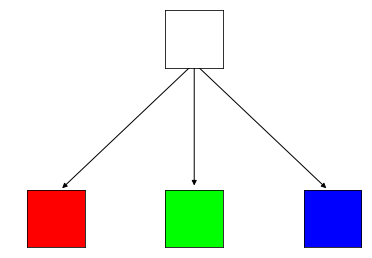

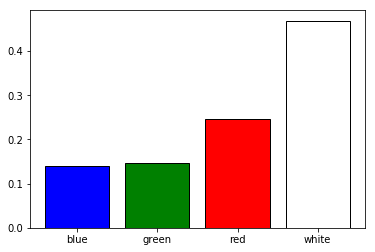

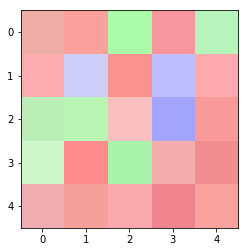

In [95]:
img, topic_weights = generate_image(image_width, two_level_tree, alpha, beta, eta)

display(two_level_tree_fig)
plot_topic_histogram(topic_weights)
plt.figure(1)
plt.imshow(img)

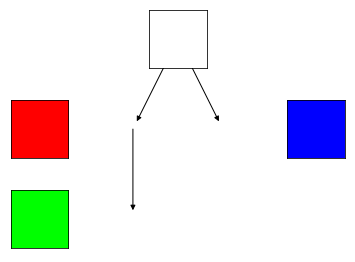

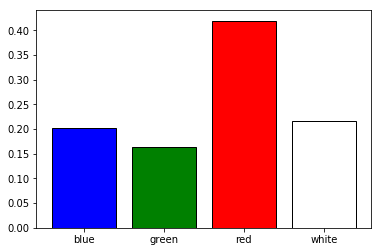

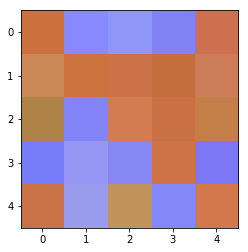

In [97]:
img, topic_weights = generate_image(image_width, three_level_tree, alpha, beta, eta)

display(three_level_tree_fig)
plot_topic_histogram(topic_weights)
plt.figure(2)
plt.imshow(img)

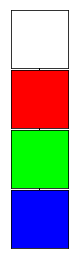

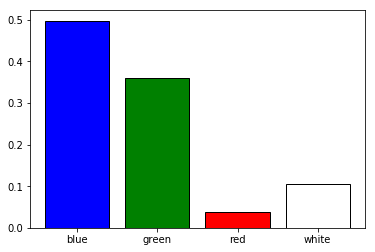

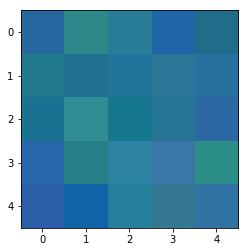

In [100]:
img, topic_weights = generate_image(image_width, four_level_tree, alpha, beta, eta)

display(four_level_tree_fig)
plot_topic_histogram(topic_weights)
plt.figure(3)
plt.imshow(img)